In [49]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
def f(x):
    return 3*x**2 - 4*x + 5

In [51]:
f(3.0)

20.0

In [52]:
xs  = np.arange(-20, 20, 1)
ys = f(xs)

In [53]:
xs,ys

(array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
          6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19]),
 array([1285, 1164, 1049,  940,  837,  740,  649,  564,  485,  412,  345,
         284,  229,  180,  137,  100,   69,   44,   25,   12,    5,    4,
           9,   20,   37,   60,   89,  124,  165,  212,  265,  324,  389,
         460,  537,  620,  709,  804,  905, 1012]))

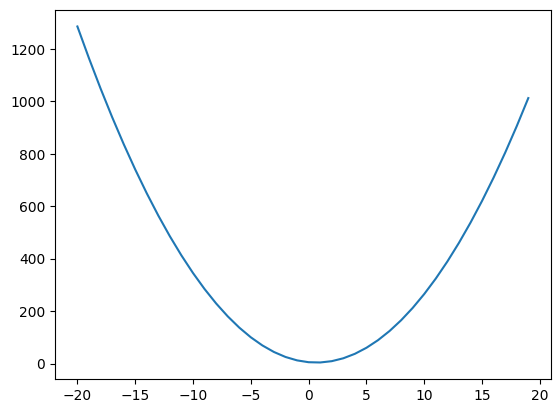

In [54]:
plt.plot(xs, ys)

In [55]:
h = 0.001
x = -3.0
f(x+h) 

43.978003

In [56]:
(f(x+h) - f(x))/h

-21.996999999998934

In [57]:
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
d

4.0

In [58]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a*b+c
d2 = (a+h)*(b)+c
print("d1-",d1,"d2-", d2)
print("slope", (d2-d1)/h)


d1- 4.0 d2- 3.999699999999999
slope -3.000000000010772


In [59]:
class Value:
    def __init__(self, data, _children=() , _op='',label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other),'+')
        return out

    def __mul__(self, other):
        out =  Value(self.data * other.data , (self, other),'*')
        return out


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b+c;d.label = 'd'


In [60]:
d._prev


{Value(data=-6.0), Value(data=10.0)}

In [61]:
d._op , d.label

('+', 'd')

In [62]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    # builds a set of nodes and edges in the graph
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir':'LR'})
    # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph ,create a rectangular node
        dot.node(name=uid, label="{data %.4f}"%(n.data),shape='record')
        
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot


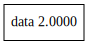

In [63]:
draw_dot(a)

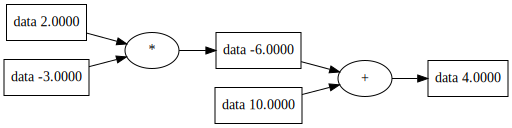

In [64]:
draw_dot(d)